In [1]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt
import numpy as np

importing NGSolve-6.2.2203


setup geometry

In [2]:
geo = SplineGeometry()
h_coarse = 0.8
h_fine = 0.15
geo.AddRectangle( (-3,-2), (3, 2), bcs = ("top", "out", "bot", "in"), leftdomain=1, rightdomain=0, maxh=h_coarse) 
geo.AddCircle(c=(0, 0), r=1, leftdomain=2, rightdomain=1, bc="outer_cylinder", maxh=h_fine) 
geo.AddCircle(c=(0, 0), r=0.5, leftdomain=0, rightdomain=2, bc="cyl", maxh=h_fine) 
#geo.SetDomainMaxH(2, 0.08)
mesh = Mesh(geo.GenerateMesh(maxh=h_coarse))
mesh.Curve(2);

geo_1 = SplineGeometry()
geo_1.AddRectangle((0,0),(1,1))
mesh_1 = Mesh(geo_1.GenerateMesh())
scene1 = Draw(mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': None…

setup FEM space

In [3]:
# Order of spaces
k = 2
# H1 vs VectorH1 -> vector field?!
V = H1(mesh,order=k, dirichlet="top|bot|cyl|in|out")
Q = H1(mesh,order=k-1)
FES = FESpace([V,V,Q]) # [V,Q] (without VectorH1)

setup bilinear form
velocityfield u and pressurefield p

In [4]:
ux,uy,p = FES.TrialFunction()
vx,vy,q = FES.TestFunction()

# stokes equation
def Equation(ux,uy,p,vx,vy,q):
    div_u = grad(ux)[0]+grad(uy)[1] # custom div
    div_v = grad(vx)[0]+grad(vy)[1]
    return (grad(ux)*grad(vx)+grad(uy)*grad(vy) + div_u*q + div_v*p).Compile() * dx


# (InnerProduct(grad(u),grad(v))+div(u)*q+div(v)*p)*dx
a = BilinearForm(FES)
a += Equation(ux,uy,p,vx,vy,q)
a.Assemble()

setup boundary conditions

In [5]:
gfu = GridFunction(FES)
uinf = 0.001
uin = CoefficientFunction((uinf))
gfu.components[0].Set(uin, definedon=mesh.Boundaries("in|top|bot|out"))

x_velocity = CoefficientFunction(gfu.components[0])
scene_state = Draw(x_velocity, mesh, "vel")

WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

solve stokes

In [6]:
def solveStokes():
    res = gfu.vec.CreateVector()
    res.data = -a.mat * gfu.vec
    inv = a.mat.Inverse(FES.FreeDofs())
    gfu.vec.data += inv * res
    scene_state.Redraw()
solveStokes()

# Calculations/Setup for all the side constraints

Drag/ "dissipated energy" [should be working]

$J(\Omega ) = \frac{1}{2} \int_\Omega Du : Du dx$ 

In [7]:
def calc_drag(gfu):
    ux = gfu.components[0]
    uy = gfu.components[1]
    return 0.5*(grad(ux)*grad(ux)+grad(uy)*grad(uy)).Compile()*dx

### get surface area of mesh (main issue)
$vol(\Omega) = \int_{\Omega} 1 \,dx \in \mathbb{R}$ should stay constant <br>
entire area: $A = 6*4=24$ <br>
$\alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2$

In [8]:
alpha = 1e-4
surf_t = CoefficientFunction(1)
surf_0 = Integrate(surf_t,mesh)

def calc_surf_change():
    return alpha*(surf_t*dx-surf_0)**2

### barycenter (not necessarily useful yet)
$bc^\Omega = \frac{1}{vol(\Omega)}\int_{\Omega}x\,dx \in \mathbb{R}^d$ for each dimension!!

In [9]:
bc_tx = CoefficientFunction(x)
bc_ty = CoefficientFunction(y)
bc_0x = 1/surf_0*Integrate(bc_tx,mesh)
bc_0y = 1/surf_0*Integrate(bc_ty,mesh)

In [10]:
def Cost(gfu):
    return calc_drag(gfu) + calc_surf_change()# + calc_bc_change()

# creation of Shapediff Space + pertubation Function
function that will perturb our mesh

In [11]:
# Test and trial functions for shape derivate -> do we even need this?
VEC = H1(mesh, order=2, dim=2, dirichlet="top|bot|in|out")
PHI, X = VEC.TnT()
# gfset denotes the deformation of the original domain and will be updated during the shape optimization
gfset = GridFunction(VEC)
gfset.Set((0,0))
mesh.SetDeformation(gfset)
SetVisualization (deformation=True)

# deformation calculation
gfX = GridFunction(VEC)

# Shape Optimization
$\min_{h,u,s} \int_{\Omega(s)} \sum_{i,j=1}^2 \left( \frac{\partial u_i}{\partial x_j}\right)^2~\mathrm{d} x
 + \alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2
+ \beta\sum_{j=1}^2 \Big(\mathrm{Bc}_j(\Omega(s))-\mathrm{Bc}_j(\Omega_0)\Big)^2,$

$\frac{1}{2} \int_\Omega Du : Du dx + \alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2
+ \beta\sum_{j=1}^2 \Big(\mathrm{Bc}_j(\Omega(s)) - \mathrm{Bc}_j(\Omega_0)\Big)^2,$ (1)

In [12]:
ux = gfu.components[0]
uy = gfu.components[1]
p = gfu.components[2]

vol = Parameter(1)
vol.Set(Integrate(surf_t,mesh))

Lagrangian = Equation(ux,uy,p,ux,uy,p) + calc_drag(gfu) #  

In [13]:
dJOmega = LinearForm(VEC)
dJOmega += Lagrangian.DiffShape(X)

# volume side constraint
vol = Parameter(1)
vol.Set(Integrate(surf_t,mesh))
alpha0 = 1e-4
alpha = Parameter(alpha0)
#dJOmega += ((2*alpha*((vol-surf_0))*vol)*dx).DiffShape(X).Compile().DiffShape(X) # (definedon="mesh_1")
dJOmega += 2*alpha*(vol-surf_0)*div(X)*dx

# barycenter x sideconstraint
beta0 = 1e-3
beta = Parameter(beta0)
bc_x = Parameter(1)
bc_x.Set((1/surf_0)*Integrate(bc_tx,mesh))
dJOmega += 2*beta*(bc_x-bc_0x)*((1/vol**2)*div(X)*x+(1/vol)*div(X)*x*sum(gfset.vecs[0].data)[0])*dx

# barycenter y sideconstraint
bc_y = Parameter(1)
bc_y.Set((1/surf_0)*Integrate(bc_ty,mesh))
dJOmega += 2*beta*(bc_y-bc_0y)*((1/vol**2)*div(X)*y+(1/vol)*div(X)*y*sum(gfset.vecs[0].data)[1])*dx


b = BilinearForm(VEC)
#b += (InnerProduct(grad(X),grad(PHI))).Compile() *dx + (InnerProduct(X,PHI)).Compile()*dx
b += (InnerProduct(grad(X),grad(PHI)+grad(PHI).trans)).Compile() *dx + (InnerProduct(X,PHI)).Compile()*dx

#Cauchy-Riemann Penalisation
gamma0 = 4
gamma = Parameter(gamma0)
b += gamma*(PHI.Deriv()[0,0] - PHI.Deriv()[1,1])*(X.Deriv()[0,0] - X.Deriv()[1,1])*dx
b += gamma*(PHI.Deriv()[1,0] - PHI.Deriv()[0,1])*(X.Deriv()[1,0] - X.Deriv()[0,1])*dx

In [14]:
def updateParams(v=False):
    vol.Set(Integrate(surf_t,mesh))
    bc_x.Set((1/surf_0)*Integrate(bc_tx,mesh))
    bc_y.Set((1/surf_0)*Integrate(bc_ty,mesh))
    if(v):
        print(vol.Get(), bc_x.Get(), bc_y.Get())
updateParams()

def increaseParams(k=2,v=False):
    alpha.Set(alpha.Get()*k)
    beta.Set(beta.Get()*k)
    #gamma.Set(gamma.Get()*k)
    if(v):
        print("alpha: ", alpha.Get(), ", beta: ", beta.Get(), ", gamma: ", gamma.Get())

In [15]:
def SolveDeformationEquation():
    rhs = gfX.vec.CreateVector()
    rhs.data = dJOmega.vec - b.mat * gfX.vec
    update = gfX.vec.CreateVector()
    update.data = b.mat.Inverse(VEC.FreeDofs()) * rhs
    gfX.vec.data += update

In [16]:
scene = Draw(gfX)

WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

# Iterations done properly

In [17]:
gfset.Set((0,0))
mesh.SetDeformation(gfset)
scene.Redraw()

updateParams()
alpha0 = 1e-4
beta0 = 1e-4
gamma0 = 160
alpha.Set(alpha0)
beta.Set(beta0)
gamma.Set(gamma0)

a.Assemble()
solveStokes()

data = [[] for x in range(7)]

iter_max = 2000
Jold = Integrate(calc_drag(gfu), mesh)

# try parts of loop
mesh.SetDeformation(gfset)
scene.Redraw()

# input("Press enter to start optimization")
for i in range(0,iter_max):
    mesh.SetDeformation(gfset)
    scene.Redraw()
    scene_state.Redraw()
    
    if i%50 == 0:
        print('drag at iteration', i, ': ', Jold)
        
    titles = ["drag","volume","bc_x","bc_y","scale","gfxnorm","gfxbndnorm"] # collecting data
    data[0].append(Integrate(calc_drag(gfu),mesh))
    data[1].append(vol.Get())
    data[2].append(bc_x.Get())
    data[3].append(bc_y.Get())
    
    a.Assemble()
    solveStokes()
    
    b.Assemble()
    dJOmega.Assemble()
    SolveDeformationEquation()
    updateParams()
    
    Jnew = Integrate(calc_drag(gfu), mesh)
    mesh.UnsetDeformation()
    
    gfxnorm = Norm(gfX.vec)
    gfxbndnorm = Norm(Integrate(gfX,mesh,BND))
    data[6].append(gfxbndnorm)
    #scale = 0.1 / Norm(gfX.vec)
    scale = 0.01 / gfxnorm
    data[4].append(scale)
    jdiff = abs(Jnew-Jold)
    data[5].append(gfxnorm)
    
    #if(gfxnorm < 1e-5):
    if(gfxbndnorm < 1e-9):
        if alpha.Get() < 100:
            increaseParams(2,True)
        else:
            print("alpha too big")
            break
            
    gfsetOld = gfset
    gfset.vec.data -= scale * gfX.vec
    Jold = Jnew

    Redraw(blocking=True)

drag at iteration 0 :  1.0997040785272935e-05
drag at iteration 50 :  9.65762453002933e-06
alpha:  0.0002 , beta:  0.0002 , gamma:  160.0
alpha:  0.0004 , beta:  0.0004 , gamma:  160.0
alpha:  0.0008 , beta:  0.0008 , gamma:  160.0
alpha:  0.0016 , beta:  0.0016 , gamma:  160.0
alpha:  0.0032 , beta:  0.0032 , gamma:  160.0
alpha:  0.0064 , beta:  0.0064 , gamma:  160.0
drag at iteration 100 :  1.0199544528310978e-05
drag at iteration 150 :  1.000689602736489e-05
drag at iteration 200 :  9.805296373246542e-06
alpha:  0.0128 , beta:  0.0128 , gamma:  160.0
drag at iteration 250 :  9.735147232003969e-06
drag at iteration 300 :  9.683393445190563e-06
drag at iteration 350 :  9.579957060587803e-06
drag at iteration 400 :  9.583753155626059e-06
drag at iteration 450 :  9.539514100138675e-06
drag at iteration 500 :  9.448604953679714e-06
drag at iteration 550 :  9.464325769457559e-06
drag at iteration 600 :  9.431084996676181e-06
drag at iteration 650 :  9.349924458431327e-06
drag at iterati

Text(0, 0.5, 'Number of Elements')

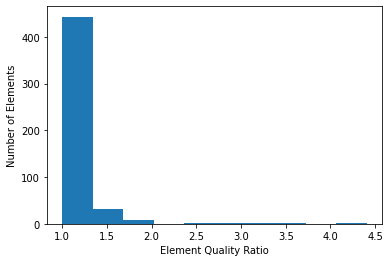

In [18]:
Element_Iterator = mesh.Elements()
Element_Quality_Data = np.empty(Element_Iterator.stop)
deformation_vector = np.asarray(gfset.vec)

# Element Quality ratio eta with sidelengths a,b,c of element K
def eta_K(abc):
    A, B, C = abc[0,:], abc[1,:], abc[2,:]
    a, b, c = np.linalg.norm(A-C), np.linalg.norm(A-B), np.linalg.norm(B-C)
    s = 1/2*(a+b+c) #half the circumference of element
    A = np.sqrt(s*(s-a)*(s-b)*(s-c)) #Area calculation with Heron Theorem
    r = 2*A / (a+b+c) # radius of inscribed circle
    R = (a*b*c) / (4*A) # radius of circumscribed circle
    eta = R / (2*r) 
    return eta

for elmnt in mesh.Elements():
    el = NodeId(ELEMENT,elmnt.nr)
    meshel = mesh[el]
    abc = np.empty([3,2])
    counter = 0

    for vert in elmnt.vertices:
        ve = NodeId(VERTEX, vert.nr)
        meshvert = mesh[ve]
        abc[counter] = np.asarray(meshvert.point) + deformation_vector[vert.nr]
        counter += 1

    counter = 0
    Element_Quality_Data[elmnt.nr] = eta_K(abc)


plt.hist(Element_Quality_Data)
plt.xlabel("Element Quality Ratio")
plt.ylabel("Number of Elements")

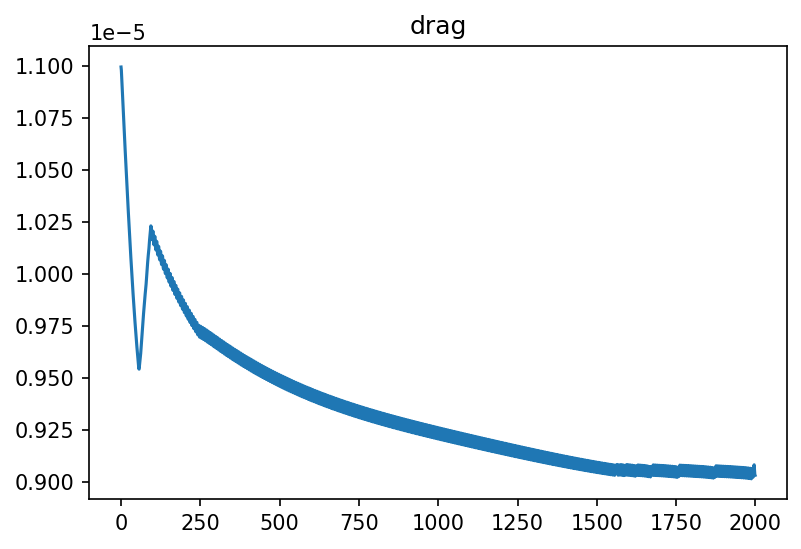

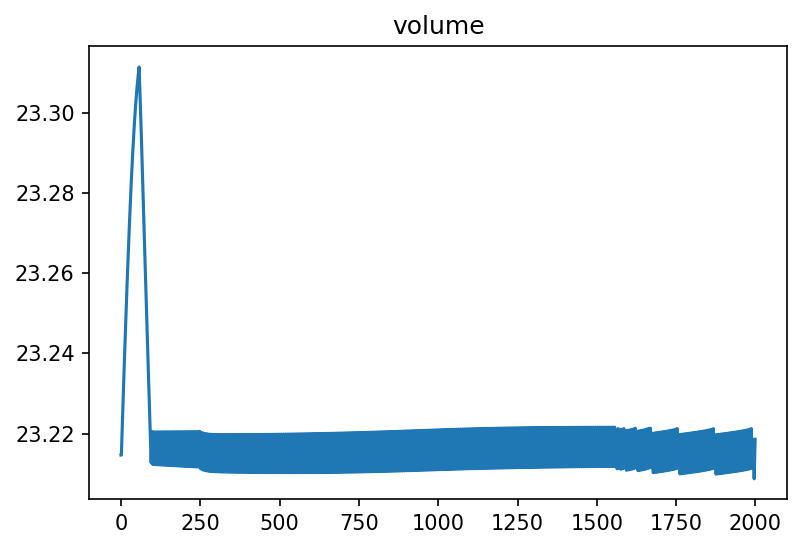

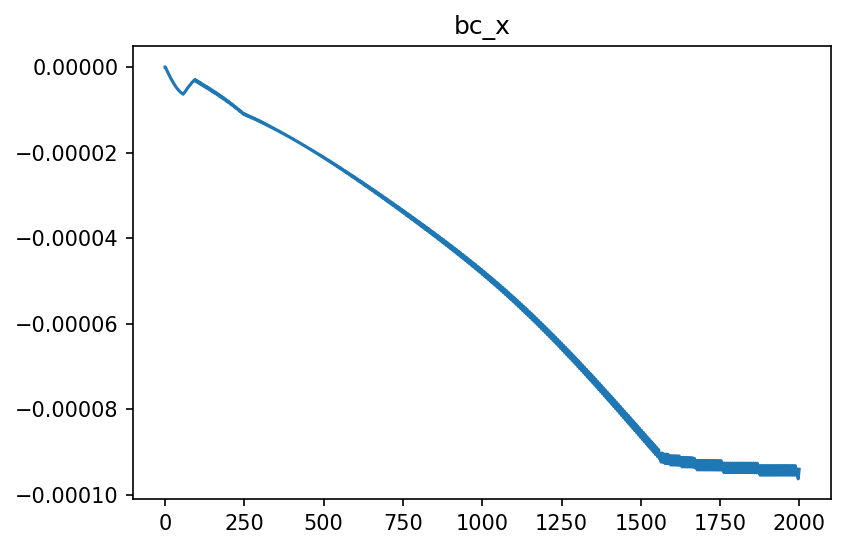

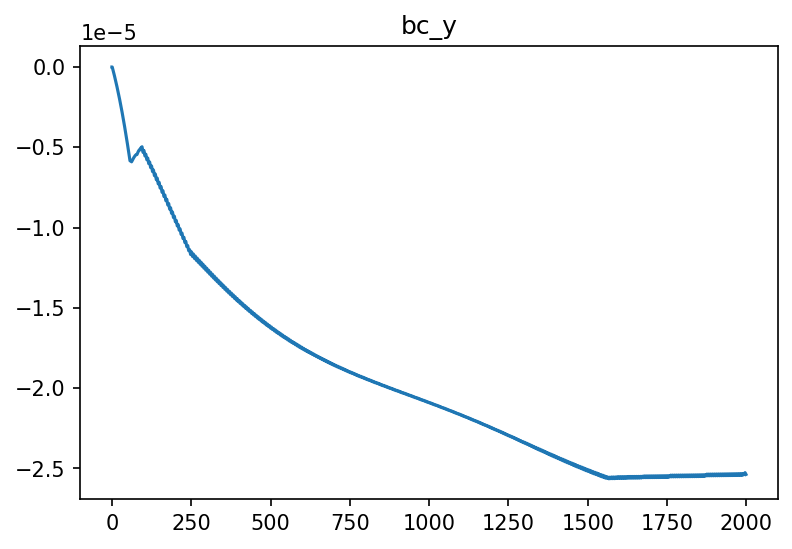

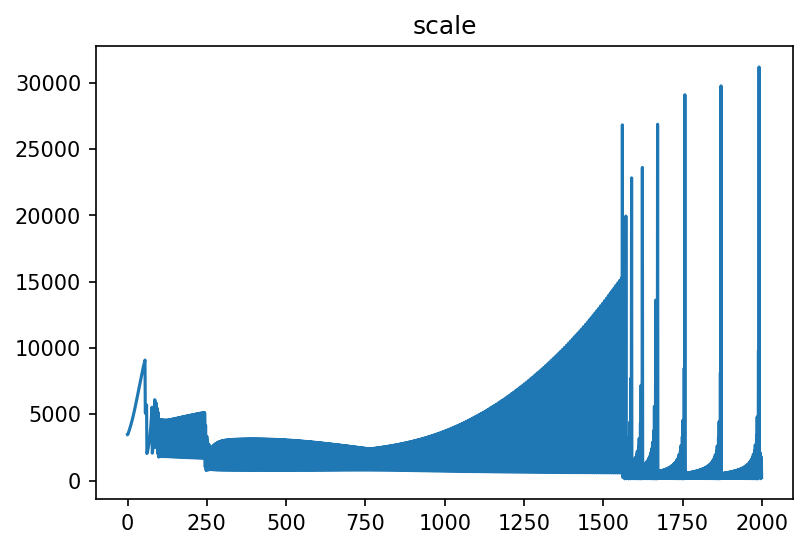

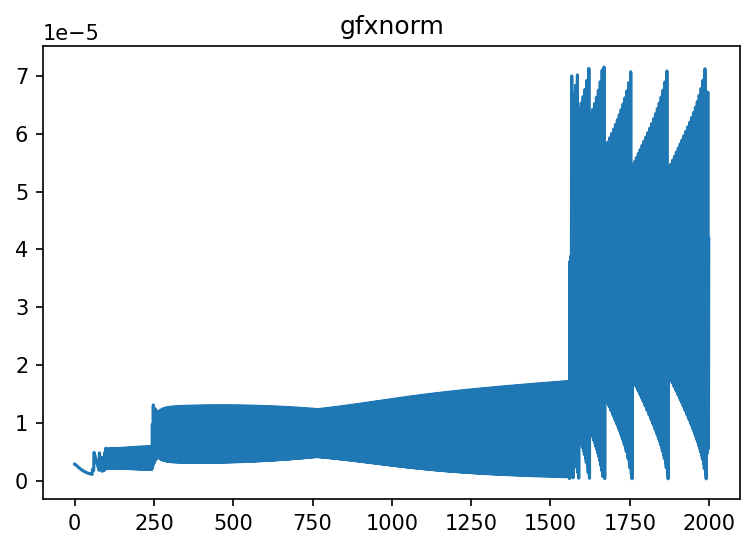

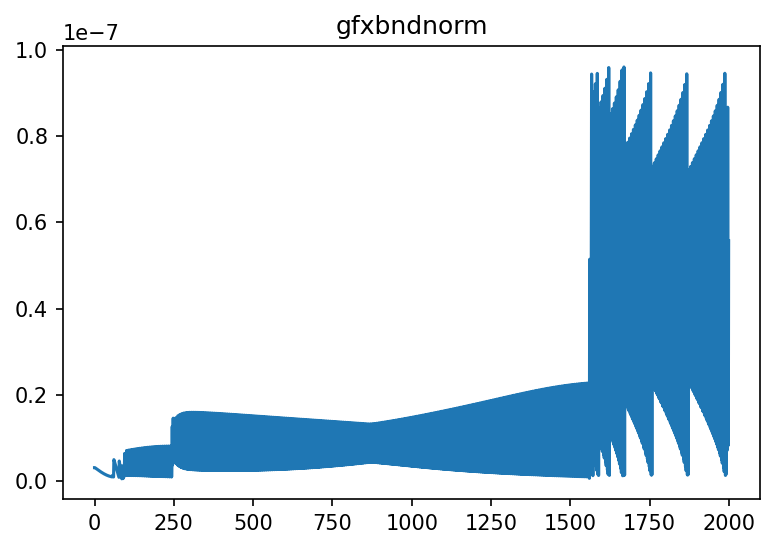

In [19]:
plt.rcParams['figure.dpi'] = 150
c = 0
for e in data:
    plt.figure(c)
    plt.title(titles[c])
    plt.plot(range(len(e)),e)
    c += 1

[3.1347327314134275e-09, 3.135764563837267e-09, 3.082463562059674e-09, 3.0288341033957293e-09, 2.9752386794303675e-09, 2.9217113727022873e-09, 2.8682844162700617e-09, 2.81499022679361e-09, 2.7618614104286215e-09, 2.708930752980019e-09, 2.6562312075399382e-09, 2.6037958791089543e-09, 2.551658006149208e-09, 2.4998509383487455e-09, 2.4484081108843366e-09, 2.397363014030119e-09, 2.3467491584137356e-09, 2.296600035015332e-09, 2.2469490698225914e-09, 2.1978295725031267e-09, 2.1492746789088583e-09, 2.1013172868028783e-09, 2.0539899847711184e-09, 2.007324973684124e-09, 1.9613539809998012e-09, 1.91610816729285e-09, 1.8716180256137986e-09, 1.8279132733562362e-09, 1.7850227375025958e-09, 1.7429742334901063e-09, 1.7017944388756458e-09, 1.6615087624328441e-09, 1.6221412105965283e-09, 1.583714252363294e-09, 1.5462486848264134e-09, 1.5097635013332618e-09, 1.4742757646907793e-09, 1.4398004874874216e-09, 1.4063505226511433e-09, 1.3739364664913527e-09, 1.3425665762150144e-09, 1.3122467053867408e-09, 1.2

ValueError: x and y must have same first dimension, but have shapes (500,) and (2000,)

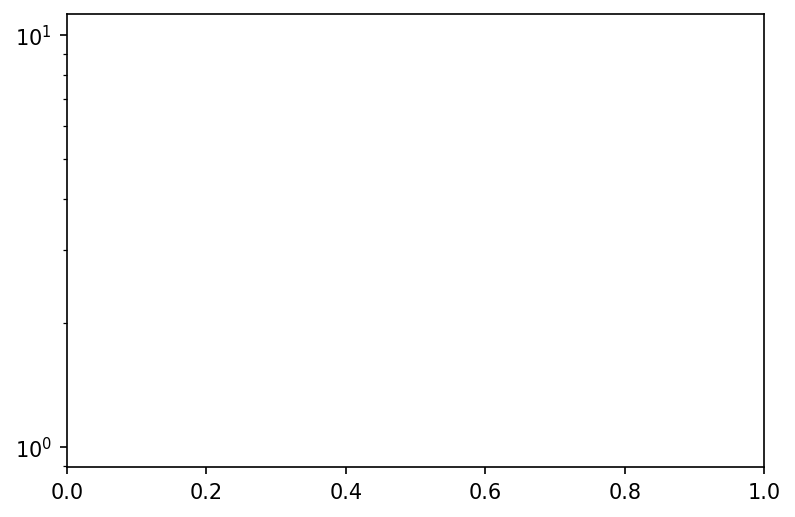

In [20]:
print(data[6])
plt.semilogy(range(0,500),data[6])